In [2]:
# origin dataset links
# kaggle datasets : "soumikrakshit/anime-faces"

In [20]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch.optim as optim
import torch
import torch.nn as nn
import cv2

import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm




In [4]:
data_dir = 'Anime-Face_Dataset\data'

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Ankit Chaudhary\AppData\Local\Temp\ipykernel_16128\1567432895.py:1: SyntaxWarning: invalid escape sequence '\d'
  data_dir = 'Anime-Face_Dataset\data'


In [5]:
image_size = 64
batch_size = 256
stats = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [6]:
train_ds = ImageFolder(data_dir ,transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)
]))


In [7]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [8]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [9]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

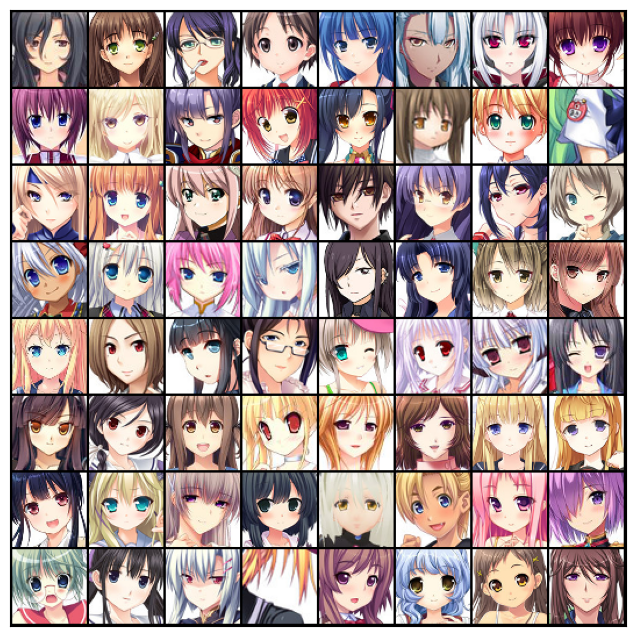

In [10]:
show_batch(train_dl)

In [11]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [13]:
train_dl = DeviceDataLoader(train_dl, device)

In [14]:
for i,j  in train_dl:
    print(i.shape ,j)
    break

torch.Size([256, 3, 64, 64]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [15]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, latent_dim=100):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            # Input: 3 x 64 x 64
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 64 x 16 x 16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128 x 8 x 8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Flatten(),  # 128 * 8 * 8
            nn.Linear(128 * 8 * 8, latent_dim)
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim=100):
        super(Decoder, self).__init__()
        self.latent_to_features = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            # Input: 128 x 8 x 8
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 64 x 16 x 16
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # 3 x 64 x 64
            nn.Tanh()
        )

    def forward(self, x):
        x = self.latent_to_features(x)
        x = x.view(-1, 128, 8, 8)  # Reshape to match expected input
        return self.decoder(x)

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=100):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [16]:
def train_autoencoder(train_dl, num_epochs=100, device='cuda'):
    # Instantiate the Autoencoder with latent_dim=100
    autoencoder = Autoencoder(latent_dim=100)
    autoencoder.to(device)
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

    criterion = nn.MSELoss()
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_idx, (data, _) in tqdm(enumerate(train_dl), desc=f'Epoch {epoch+1}/{num_epochs}'):
            # Move data to device
            data = data.to(device)

            # Reset gradients
            optimizer.zero_grad()

            # Forward pass using the Autoencoder
            reconstructed = autoencoder(data)

            # Calculate loss
            loss = criterion(reconstructed, data)

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Calculate average epoch loss
        avg_loss = epoch_loss / len(train_dl)
        losses.append(avg_loss)

        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

        # Visualize results every 20 epochs (assuming visualize_results function is defined)
        if (epoch + 1) % 20 == 0:
            # Pass the autoencoder to visualize_results
            visualize_results(autoencoder, data, device)

    return autoencoder, losses  # Return the autoencoder


In [17]:
'''input_shape = (1, 128,4,4)

model = Decoder()
random_input = torch.randn(input_shape)

output = model(random_input)

print(f'Random input: {random_input.shape}')

tensor = output.squeeze(0)  # Resulting shape: (3, 64, 64)
tensor = tensor.permute(1, 2, 0)  # Resulting shape: (64, 64, 3)
image = tensor.detach().numpy()
plt.imshow(image)
plt.show()'''


"input_shape = (1, 128,4,4)\n\nmodel = Decoder()\nrandom_input = torch.randn(input_shape)\n\noutput = model(random_input)\n\nprint(f'Random input: {random_input.shape}')\n\ntensor = output.squeeze(0)  # Resulting shape: (3, 64, 64)\ntensor = tensor.permute(1, 2, 0)  # Resulting shape: (64, 64, 3)\nimage = tensor.detach().numpy()\nplt.imshow(image)\nplt.show()"

In [18]:
for i in train_dl:
    print(i[0].shape)
    break

torch.Size([256, 3, 64, 64])


In [ ]:
import torch
import matplotlib.pyplot as plt

def visualize_results(model, data, device, num_images=5):
    """Visualize original and reconstructed images"""
    model.eval()
    with torch.no_grad():
        # Get sample images and reconstructions
        samples = data[:num_images].to(device)
        reconstructed = model(samples)

        # Move tensors to CPU for visualization
        samples = samples.cpu()
        reconstructed = reconstructed.cpu()

        # Plot results
        plt.figure(figsize=(12, 4))
        for i in range(num_images):
            # Plot original
            plt.subplot(2, num_images, i + 1)
            plt.imshow((samples[i].permute(1, 2, 0).numpy() * 0.5) + 0.5)  # Scale images if needed
            plt.axis('off')
            plt.title('Original')

            # Plot reconstruction
            plt.subplot(2, num_images, i + num_images + 1)
            plt.imshow((reconstructed[i].permute(1, 2, 0).numpy() * 0.5) + 0.5)  # Scale images if needed
            plt.axis('off')
            plt.title('Reconstructed')

        plt.tight_layout()
        plt.show()
    model.train()




# Plot training losses
def plot_losses(losses):
    plt.figure(figsize=(10, 4))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model, training_losses = train_autoencoder(train_dl, num_epochs=100, device=device)
plot_losses(training_losses)


In [ ]:
torch.save(model.encoder.state_dict(), 'encoder1.pth')
torch.save(model.decoder.state_dict(), 'decoder1.pth')



In [ ]:
#generate new image with  random latent varable

encoder = Encoder(latent_dim=128)
decoder = Decoder(latent_dim=128)

encoder.load_state_dict(torch.load('encoder.pth'))
decoder.load_state_dict(torch.load('decoder.pth'))

encoder.eval()
decoder.eval()



import matplotlib.pyplot as plt

# Move models to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder.to(device)
decoder.to(device)

# Example input image tensor
image_tensor = torch.randn(1, 3, 64, 64).to(device)

# Pass through encoder and decoder
with torch.no_grad():  # Disable gradient calculation for inference
    latent_representation = encoder(image_tensor)
    reconstructed_image = decoder(latent_representation)

# Move the reconstructed image to CPU and convert to NumPy array
reconstructed_image = reconstructed_image.squeeze().permute(1, 2, 0).cpu().numpy()

# Display the image
plt.imshow(reconstructed_image)
plt.show()
